# 0 Domande di ricerca

- E' possibile rappresentare in una finestra di 30 minuti l'intera popolazione di tweet in relazione al sentiment?

# 1 Estrazione dataset e script

In [3]:
source("../RuntimEnviroment/my_function.R")

Funzioni caricate con successo

In [4]:
df <- load_csv_file("../Dataset/Sentiment_en_tweet_2023.csv")

Il file è stato trovato: ../Dataset/Sentiment_en_tweet_2023.csv 
Contenuto del file CSV:
        userid        username
1 2.224061e+07   AlArabiya_Eng
2 1.252283e+08     apple2hotel
3 1.365269e+18 TerryTheTipste1
4 1.295405e+18 MayadeenEnglish
5 1.508116e+18   FloranceOlman
6 1.616511e+18  NUHerbalHealth
                                                                                                                                                   acctdesc
1                                                                                             The Arab worldâ\200\231s leading source of global news and opinion.
2                                    Travel bookings can be made online through a travel  website through a traditional travel agent.\n#travel #travelbuddy
3            Sports Nut, Tipping Enthusiast. 80s music addict who loves betting on horses and all sport. Follow for FREE Betting Tips on variety of Sports.
4                                                               

# 2 Definizione delle variabili aleatorie

## 2.1 Estrazione tweet in una finestra di 30 minuti

In [3]:
library(dplyr)
library(lubridate)  # Per lavorare facilmente con date e orari

# Assumendo che la colonna sia già in formato "anno-mese-giorno ore:minuti:secondi"
# Verifico che la colonna sia di tipo POSIXct
if (!inherits(df$tweetcreatedts, "POSIXct")) {
  dff <- df %>%
    mutate(tweetcreatedts = as.POSIXct(tweetcreatedts, format = "%Y-%m-%d %H:%M:%S"))
}

# Calcolo l'intervallo temporale (primi 30 minuti)
start_time <- min(dff$tweetcreatedts, na.rm = TRUE)  # Primo timestamp
end_time <- start_time + minutes(30)  # Aggiungi 30 minuti

# Filtro i dati nel range specificato
df_30min <- dff %>%
  filter(tweetcreatedts >= start_time & tweetcreatedts < end_time)

# Numero di tweet generati
num_tweets <- nrow(df_30min)

# Tweet con time series minima e massima
min_tweet <- df_30min %>% filter(tweetcreatedts == min(tweetcreatedts))
max_tweet <- df_30min %>% filter(tweetcreatedts == max(tweetcreatedts))

# Stampo i risultati
cat("Numero di tweet generati nei primi 30 minuti:", num_tweets, "\n")
cat("Tweet con la time series minima:\n")
print(min_tweet)
cat("Tweet con la time series massima:\n")
print(max_tweet)


Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union



Caricamento pacchetto: 'lubridate'


I seguenti oggetti sono mascherati da 'package:base':

    date, intersect, setdiff, union




Numero di tweet generati nei primi 30 minuti: 751 
Tweet con la time series minima:
        userid        username
1 2.224061e+07   AlArabiya_Eng
2 1.252283e+08     apple2hotel
3 1.365269e+18 TerryTheTipste1
4 1.295405e+18 MayadeenEnglish
                                                                                                                                        acctdesc
1                                                                                  The Arab worldâ\200\231s leading source of global news and opinion.
2                         Travel bookings can be made online through a travel  website through a traditional travel agent.\n#travel #travelbuddy
3 Sports Nut, Tipping Enthusiast. 80s music addict who loves betting on horses and all sport. Follow for FREE Betting Tips on variety of Sports.
4                                                                                       The official Twitter page of Al Mayadeen English Website
                  location fol

# 3 Stima puntuale

## 3.1 Stampa numero di tweet con sentiment negativi

In [4]:
library(dplyr)

# Estraggo solo i tweet con sentiment positivo
df_30min_neg <- df_30min %>% filter(sentiment=="neg")

# Numero di tweet generati
num_tweets_neg <- nrow(df_30min_neg)

cat("Numero di tweet positivi nei primi 30 minuti:", num_tweets_neg, "\n")
cat("Numero di tweet totali nei primi 30 minuti:", num_tweets, "\n\n")
cat("Probabilità 'campionaria' relativa ai sentiment negativi:", num_tweets_neg/num_tweets, "\n")

Numero di tweet positivi nei primi 30 minuti: 429 
Numero di tweet totali nei primi 30 minuti: 751 

Probabilità 'campionaria' relativa ai sentiment negativi: 0.5712383 


# 4 Intervallo di confidenza

## 4.1 Verifico se la distribuzione segue una normale approssimativa

Per far sì che si approssima alla normale è necessario che np^>5 e che n(1-p^)>5 dove:
- n: numero tweet
- p^: proporzione tweet negativi
- 1-p^: proporzione tweet non negativi

In [5]:
# Ricavo la proporzione
p <- num_tweets_neg/num_tweets

# Ricavo gli elementi di verifica
np <- num_tweets*p
np_neg <- num_tweets*(1-p)

# Stampa degli elementi di verifica
cat("np =", np, "\nn(1-p) =", np_neg, "\n")

# Verifica della distribuzione
if (np > 5 && np_neg > 5) {
  cat("La distribuzione dei tweet è un'approssimazione della normale\n")
} else {
  cat("La distribuzione dei tweet NON è un'approssimazione della normale\n")
}


np = 429 
n(1-p) = 322 
La distribuzione dei tweet è un'approssimazione della normale


## 4.2 Stampa del plot che verifica tale affermazione

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


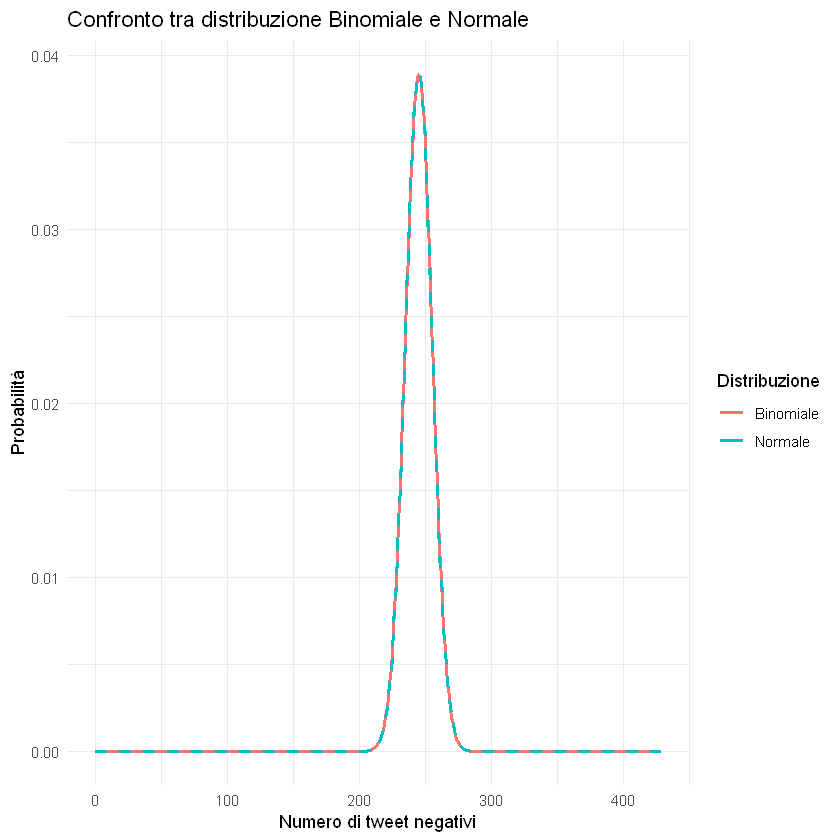

In [6]:
library(ggplot2)

# Calcolo dei valori attesi dalla distribuzione normale
x <- 0:num_tweets_neg  # Possibili valori di tweet "negativi"
mu <- num_tweets_neg * p  # Media della distribuzione binomiale [E(X) = np]
sigma <- sqrt(num_tweets_neg * p * (1 - p))  # Deviazione standard della distribuzione binomiale [sqrt(VAR(X) = sqrt(kp(1-p)]

y_binom <- dbinom(x, size = num_tweets_neg, prob = p)  # Probabilità binomiale
y_norm <- dnorm(x, mean = mu, sd = sigma)  # Probabilità della normale approssimata

# Creazione del dataframe per il plot
data_plot <- data.frame(
  x = x,
  Binomiale = y_binom,
  Normale = y_norm
)

# Plot delle due distribuzioni
ggplot(data_plot, aes(x = x)) +
  geom_line(aes(y = Binomiale, color = "Binomiale"), size = 1) +
  geom_line(aes(y = Normale, color = "Normale"), linetype = "dashed", size = 1) +
  labs(title = "Confronto tra distribuzione Binomiale e Normale",
       x = "Numero di tweet negativi",
       y = "Probabilità",
       color = "Distribuzione") +
  theme_minimal()


## 4.3 Calcolo dell'intervallo di confidenza

fonti: intervallo di confidenza per grandi campioni - binomiale

In [7]:
# Stima dei parametri
p_hat <- num_tweets_neg / num_tweets  # Proporzione stimata
mu_hat <- num_tweets * p_hat          # Media stimata
sigma_hat <- sqrt(num_tweets * p_hat * (1 - p_hat))  # Deviazione standard stimata

# Intervallo di confidenza
alpha <- 0.05  # Livello di significatività (per il 95% CI)
z_alpha <- qnorm(1 - alpha / 2, mean=0, sd=1)  # Valore critico della normale standard

cat("Valore critico della normale standard: ",z_alpha,"\n");

ci_lower <- p_hat - z_alpha * sqrt(p_hat * (1 - p_hat) / num_tweets)
ci_upper <- p_hat + z_alpha * sqrt(p_hat * (1 - p_hat) / num_tweets)

cat("Intervallo di confidenza al 95% per la proporzione:", "\n")
cat("Inferiore:", ci_lower, "\nSuperiore:", ci_upper, "\n")


Valore critico della normale standard:  1.959964 
Intervallo di confidenza al 95% per la proporzione: 
Inferiore: 0.5358431 
Superiore: 0.6066336 


In [10]:
p_hat <- num_tweets_neg / num_tweets

alpha <- 0.05
zalpha <- qnorm(1 - alpha/2, mean=0, sd=1)
n <- num_tweets
lanci <- 1 # Importante: lanci = 1 in questo contesto num_tweets

a2 <- lanci*(n*lanci + zalpha^2)
a1 <- -lanci*(2*n*p_hat + zalpha^2)
a0 <- n*(p_hat)^2

radici <- polyroot(c(a0, a1, a2))
ci_lower_quad <- min(Re(radici)) # Prendo la parte reale e il minimo
ci_upper_quad <- max(Re(radici)) # Prendo la parte reale e il massimo


cat("Intervallo di confidenza con soluzione quadratica:\n")
cat("Inferiore:", ci_lower_quad, "\nSuperiore:", ci_upper_quad, "\n")

ci_lower <- p_hat - zalpha * sqrt(p_hat * (1 - p_hat) / num_tweets)
ci_upper <- p_hat + zalpha * sqrt(p_hat * (1 - p_hat) / num_tweets)

cat("Intervallo di confidenza con approssimazione normale:\n")
cat("Inferiore:", ci_lower, "\nSuperiore:", ci_upper, "\n")

Intervallo di confidenza con soluzione quadratica:
Inferiore: 0.5355689 
Superiore: 0.6061827 
Intervallo di confidenza con approssimazione normale:
Inferiore: 0.5358431 
Superiore: 0.6066336 


# 5 Ipotesi e test

Formulazione delle ipotesi:
- 𝐻0: 𝑝 = 0.5712383
- H0: p != 0.5712383

In [16]:
p0 <- 0.606
alpha <- 0.05

# Approssimazione Normale
z <- (p_hat - p0) / sqrt(p0 * (1 - p0) / n)
z_crit <- qnorm(1 - alpha/2)
p_value <- 2 * (1 - pnorm(abs(z)))

cat("Approssimazione Normale:\n")
cat("Statistica test z:", z, "\n")
cat("Valore critico z:", z_crit, "\n")
cat("P-value:", p_value, "\n")

if (abs(z) > z_crit) {
  cat("Rifiuto H0\n")
} else {
  cat("Non rifiuto H0\n")
}

# Soluzione Quadratica
a2 <- n + z_crit^2
a1 <- -2 * n * p_hat - z_crit^2
a0 <- n * p_hat^2

radici <- polyroot(c(a0, a1, a2))
ci_lower_quad <- min(Re(radici))
ci_upper_quad <- max(Re(radici))

cat("\nSoluzione Quadratica:\n")
cat("Intervallo di Confidenza: (", ci_lower_quad, ",", ci_upper_quad, ")\n")

if (p0 < ci_lower_quad || p0 > ci_upper_quad) {
  cat("Rifiuto H0\n")
} else {
  cat("Non rifiuto H0\n")
}

Approssimazione Normale:
Statistica test z: -1.949557 
Valore critico z: 1.959964 
P-value: 0.05122894 
Non rifiuto H0

Soluzione Quadratica:
Intervallo di Confidenza: ( 0.5355689 , 0.6061827 )
Non rifiuto H0


# 6 Test del chi-quadrato

In [27]:
# Estraggo il numero di sentiment da df
sentiment_table <- table(df$sentiment)
sentiment_vector <- as.vector(sentiment_table)
names(sentiment_vector) <- names(sentiment_table) # Mantieni i nomi per chiarezza

print(sentiment_vector)

   neg    neu    pos 
467532 208415 100642 


In [26]:
# Estraggo il numero di sentiment da df
sentiment_table_30min <- table(df_30min$sentiment)
sentiment_vector_30min <- as.vector(sentiment_table_30min)
names(sentiment_vector_30min) <- names(sentiment_table_30min) # Mantieni i nomi per chiarezza

print(sentiment_vector_30min)

neg neu pos 
429 234  88 


In [30]:
# Verifica che i nomi siano gli stessi e nello stesso ordine (ESSENZIALE!)
if(!identical(names(sentiment_vector), names(sentiment_vector_30min))) {
  stop("Errore: I nomi dei vettori non corrispondono. Assicurati che le categorie siano le stesse e nello stesso ordine.")
}

# Calcolo del chi-quadrato
chi2 <- sum((sentiment_vector - sentiment_vector_30min)^2 / sentiment_vector)

# Gradi di libertà
df <- length(sentiment_vector) - 1

# Livello di significatività
alpha <- 0.05

# Valore critico
valore_critico <- qchisq(1 - alpha, df)

# P-value
p_value <- 1 - pchisq(chi2, df)

cat("Statistica test chi-quadrato:", chi2, "\n")
cat("Gradi di libertà:", df, "\n")
cat("Valore critico:", valore_critico, "\n")
cat("P-value:", p_value, "\n")

if (chi2 > valore_critico) {
  cat("Rifiuto l'ipotesi nulla: il campione non è rappresentativo della popolazione.\n")
} else {
  cat("Non rifiuto l'ipotesi nulla: il campione potrebbe essere rappresentativo della popolazione.\n")
}

if (p_value < alpha) {
  cat("Rifiuto l'ipotesi nulla (basato sul p-value).\n")
} else {
  cat("Non rifiuto l'ipotesi nulla (basato sul p-value).\n")
}

Statistica test chi-quadrato: 775087.7 
Gradi di libertà: 2 
Valore critico: 5.991465 
P-value: 0 
Rifiuto l'ipotesi nulla: il campione non è rappresentativo della popolazione.
Rifiuto l'ipotesi nulla (basato sul p-value).


# 7 Conclusioni

Il campione di 30 minuti è troppo piccolo per rappresentare un dataset di 7 giorni

# 8 Ricavo il minimo campione più rappresnetativo

### 8.1.1 Estrazione dataset

In [47]:
df <- load_csv_file("../Dataset/Sentiment_en_tweet_2023.csv")

Il file è stato trovato: ../Dataset/Sentiment_en_tweet_2023.csv 
Contenuto del file CSV:
        userid        username
1 2.224061e+07   AlArabiya_Eng
2 1.252283e+08     apple2hotel
3 1.365269e+18 TerryTheTipste1
4 1.295405e+18 MayadeenEnglish
5 1.508116e+18   FloranceOlman
6 1.616511e+18  NUHerbalHealth
                                                                                                                                                   acctdesc
1                                                                                             The Arab worldâ\200\231s leading source of global news and opinion.
2                                    Travel bookings can be made online through a travel  website through a traditional travel agent.\n#travel #travelbuddy
3            Sports Nut, Tipping Enthusiast. 80s music addict who loves betting on horses and all sport. Follow for FREE Betting Tips on variety of Sports.
4                                                               

### 8.1.2 funzione per generare campioni

In [76]:
estrai_elementi_casuali <- function(df, numero_elementi, restituisci_indici = FALSE) {
  # Verifico che df sia un dataframe
  if (!is.data.frame(df)) {
    stop("Errore: 'df' deve essere un dataframe.")
  }

  # Verifico che numero_elementi sia un numero intero positivo
  if (!is.numeric(numero_elementi) || numero_elementi < 1 || numero_elementi != as.integer(numero_elementi)) {
    stop("Errore: 'numero_elementi' deve essere un numero intero positivo.")
  }
    
    #Verifico che il numero di elementi richiesti non sia maggiore del numero di righe del dataframe
    if (numero_elementi > nrow(df)){
        stop("Errore: 'numero_elementi' non può essere maggiore del numero di righe del dataframe.")
    }

  # Estraggo indici casuali
  indici_casuali <- sample(1:nrow(df), numero_elementi, replace = FALSE)

  if (restituisci_indici) {
    return(indici_casuali)
  } else {
    # Estraggo le righe corrispondenti agli indici casuali
    df_casuale <- df[indici_casuali, ]
    return(df_casuale)
  }
}

# Estraggo 3 elementi casuali
df_campione <- estrai_elementi_casuali(df, 50000)
print("Dataframe con 200000 elementi casuali:\n")
print(nrow(df_campione))

[1] "Dataframe con 200000 elementi casuali:\n"
[1] 50000


# 9 Test del chi-quadrato

Ipotesi nulla (𝐻0): La distribuzione del sentiment nel campione è uguale alla distribuzione del sentiment nella popolazione.

In [77]:
# Frequenze osservate nel campione
frequenze_osservate <- table(df_campione$sentiment)

# Frequenze attese nella popolazione (calcolate come proporzioni della popolazione)
frequenze_attese <- prop.table(table(df$sentiment))

# Calcolo le frequenze attese effettive per il campione
frequenze_attese_completate <- frequenze_attese * length(df_campione$sentiment)

# Applico il test chi-quadro
test_chi2 <- chisq.test(frequenze_osservate, p = frequenze_attese_completate / sum(frequenze_attese_completate))

# Definisco una soglia di significatività
alpha <- 0.05   #ho scelto 0.05 perché risulta un ottimo bilanciamento dai tipi di errore I e II

# Visualizzo i risultati
cat("Chi-quadro:", test_chi2$statistic, "\n")
cat("Gradi di libertà:", test_chi2$parameter, "\n")
cat("P-valore:", test_chi2$p.value, "\n")

# Confronto con la soglia
if (test_chi2$p.value < alpha) {
  cat("Il risultato è significativo: rifiutiamo l'ipotesi nulla.\n")
} else {
  cat("Il risultato non è significativo: non rifiutiamo l'ipotesi nulla.\n")
}

Chi-quadro: 5.898956 
Gradi di libertà: 2 
P-valore: 0.05236703 
Il risultato non è significativo: non rifiutiamo l'ipotesi nulla.


In [87]:
print(frequenze_attese * length(df_campione$sentiment))


      neg       neu       pos 
30101.637 13418.617  6479.747 


# 10 Stima puntuale

In [79]:
# Calcolo la stima puntuale per ciascun sentiment (proporzioni)
proporzioni_sentiment <- prop.table(table(df_campione$sentiment))

# Visualizzo i risultati
print(proporzioni_sentiment)


    neg     neu     pos 
0.59978 0.27280 0.12742 


# 11 Intervalli di confidenza

In [80]:
# Calcolare la proporzione di ciascun sentiment nel campione
proporzioni_sentiment <- prop.table(table(df_campione$sentiment))

# Funzione per calcolare l'intervallo di confidenza per una proporzione
calcola_ic <- function(p, n, conf_level = 0.95) {
  Z <- qnorm(1 - (1 - conf_level) / 2)  # Valore Z per il livello di confidenza (95% -> Z = 1.96)
  errore_standard <- sqrt(p * (1 - p) / n)
  margine_errore <- Z * errore_standard
  ic_lower <- p - margine_errore
  ic_upper <- p + margine_errore
  return(c(lower = ic_lower, upper = ic_upper))
}

# Calcolare l'intervallo di confidenza per ciascuna proporzione
n <- length(df_campione$sentiment)  # Dimensione del campione
ic_sentiment <- sapply(proporzioni_sentiment, calcola_ic, n = n)

# Visualizzare gli intervalli di confidenza
print(ic_sentiment)


            neg      neu       pos
lower 0.5954855 0.268896 0.1244973
upper 0.6040745 0.276704 0.1303427


## 11.1 Verifica della validità degli intervalli di confidenza

In [81]:
# Calcolare la stima puntuale per ciascun sentiment (proporzioni)
proporzioni_sentiment <- prop.table(table(df$sentiment))

# Visualizzare i risultati
print(proporzioni_sentiment)


      neg       neu       pos 
0.6020327 0.2683723 0.1295949 


# 12 test di ipotesi

Ipotesi nulla e alternativa:

- Ipotesi nulla (H0): La proporzione dei sentiment positivi del campione è uguale a una proporzione attesa p0 = 0.1295949)
- Ipotesi alternativa (H1): La proporzione dei sentiment positivi del campione è significativamente diversa da p0 = 0.1295949)

In [83]:
# Definire la proporzione attesa (ipotesi nulla)
p_0 <- 0.1295949

# Calcolare la proporzione osservata nel campione per sentiment "pos"
p_hat <- prop.table(table(df_campione$sentiment))["pos"]

# Calcolare la dimensione del campione
n <- length(df_campione$sentiment)

# Calcolare la statistica Z
z_stat <- (p_hat - p_0) / sqrt((p_0 * (1 - p_0)) / n)

# Calcolare il p-value per il test a due code
p_value <- 2 * (1 - pnorm(abs(z_stat)))  # Test a due code

# Visualizzare i risultati
cat("Statistica Z:", z_stat, "\n")
cat("P-value:", p_value, "\n")

# Conclusione del test
if (p_value < 0.05) {
  cat("Rifiutiamo l'ipotesi nulla: la proporzione di sentiment 'pos' è significativamente diversa da ", p_0,".\n")
} else {
  cat("Non rifiutiamo l'ipotesi nulla: non c'è evidenza sufficiente per dire che la proporzione di sentiment 'pos' è diversa da ", p_0,".\n")
}


Statistica Z: -1.448004 
P-value: 0.1476161 
Non rifiutiamo l'ipotesi nulla: non c'è evidenza sufficiente per dire che la proporzione di sentiment 'pos' è diversa da  0.1295949 .


# 13 Risposta alla domanda di ricerca

## 13.1 Definizione del modello

La distribuzione di Poisson è usata per modellare il numero di eventi (in questo caso sentiment, ad esempio neg, neu, pos) che si verificano in un intervallo di tempo o spazio, assumendo che:

- Gli eventi siano indipendenti.
- La probabilità di un evento in un intervallo è proporzionale alla lunghezza dell'intervallo.
- La probabilità di due o più eventi nello stesso intervallo è trascurabile.

Vogliamo:
- Stimare il parametro 𝜆 : il tasso medio di sentiment osservati nell'intervallo 𝛾
- Confrontare il numero osservato di sentiment con quanto atteso da una distribuzione di Poisson.
- Testare l'adattamento dei dati alla distribuzione di Poisson.

## 13.2 Definizione degli intervalli

In [5]:
library(dplyr)

# Converto la colonna timestamp in un formato data-ora
df$timestamp <- as.POSIXct(df$tweetcreatedts)

# Creo una colonna con l'ora di pubblicazione (puoi scegliere altri intervalli, come il giorno)
df$ora <- format(df$timestamp, "%H")  # Ora come intervallo

In [6]:
# Conto i sentimenti per ogni intervallo di tempo (ora)
conteggio_sentiment <- df %>%
  group_by(ora, sentiment) %>%
  summarise(conteggio = n())

# Visualizzo i conteggi
print(conteggio_sentiment)


`summarise()` has grouped output by 'ora'. You can override using the `.groups` argument.


# A tibble: 72 x 3
# Groups:   ora [24]
   ora   sentiment conteggio
   <chr> <chr>         <int>
 1 00    neg           15886
 2 00    neu            6289
 3 00    pos            2984
 4 01    neg           14136
 5 01    neu            5831
 6 01    pos            2792
 7 02    neg           14076
 8 02    neu            5614
 9 02    pos            2727
10 03    neg           15141
# i 62 more rows


## 13.3 Calcolo del tasso di eventi (lambda) per la disribuzione di Poisson

In [123]:
# Calcolo il tasso medio (lambda) di sentiment per ogni intervallo di tempo
lambda_pos <- mean(conteggio_sentiment$conteggio[conteggio_sentiment$sentiment == "pos"])
lambda_neu <- mean(conteggio_sentiment$conteggio[conteggio_sentiment$sentiment == "neu"])
lambda_neg <- mean(conteggio_sentiment$conteggio[conteggio_sentiment$sentiment == "neg"])

cat("Tasso medio per sentiment pos:", lambda_pos, "\n")
cat("Tasso medio per sentiment neu:", lambda_neu, "\n")
cat("Tasso medio per sentiment neg:", lambda_neg, "\n")


Tasso medio per sentiment pos: 4193.417 
Tasso medio per sentiment neu: 8683.958 
Tasso medio per sentiment neg: 19480.5 


## 13.4 Applicare la distribuzione di Poisson

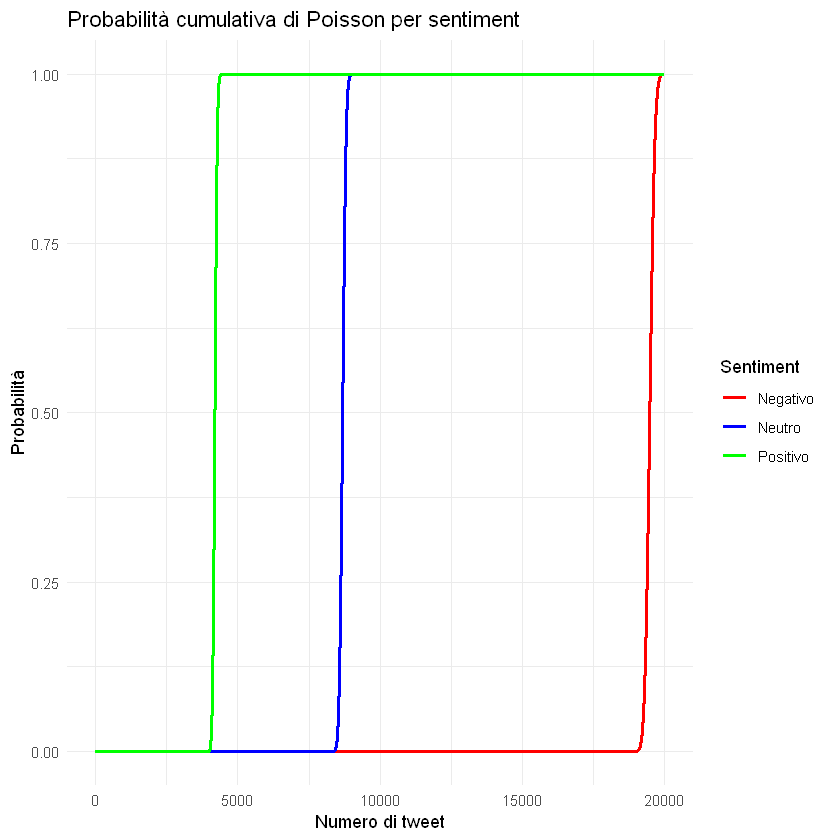

In [121]:
library(ggplot2)

# Numero massimo di tweet che vogliamo considerare
k_max <- 20000  # Numero massimo di tweet per il grafico

# Creo una sequenza di valori di k
k_values <- 0:k_max

# Calcolo la probabilità cumulativa di Poisson per ciascun sentiment (pos, neu, neg)
prob_pos <- ppois(k_values, lambda_pos)
prob_neu <- ppois(k_values, lambda_neu)
prob_neg <- ppois(k_values, lambda_neg)

# Creo un dataframe per il grafico
df_prob <- data.frame(
  k = rep(k_values, 3),
  prob = c(prob_pos, prob_neu, prob_neg),
  sentiment = rep(c("Positivo", "Neutro", "Negativo"), each = length(k_values))
)

# Creo il grafico con ggplot2
ggplot(df_prob, aes(x = k, y = prob, color = sentiment)) + 
  geom_line(size = 1) + 
  labs(title = "Probabilità cumulativa di Poisson per sentiment",
       x = "Numero di tweet",
       y = "Probabilità",
       color = "Sentiment") + 
  theme_minimal() + 
  scale_color_manual(values = c("Positivo" = "green", "Neutro" = "blue", "Negativo" = "red"))


## 13.5 Test di adattamento alla distribuzione di Poisson (usando solo pos)

In [10]:
# Sentimenti positivi per ogni ora
camppois <- conteggio_sentiment$conteggio[conteggio_sentiment$sentiment == "pos"]

# Numero totale di eventi (sentimenti positivi)
n <- length(camppois)

# Frequenze osservate per ogni conteggio (tabella delle frequenze)
freq <- table(camppois)

# Stima di lambda (media degli eventi per ora)
stimalambda <- mean(camppois)

# Valori unici dei conteggi osservati
valori <- as.numeric(names(freq))

# Calcolo delle probabilità teoriche di Poisson
prob_poisson <- dpois(valori, lambda = stimalambda)

# Calcolo delle frequenze attese
frequenze_attese <- sum(freq) * prob_poisson

# Calcolo la statistica chi-quadrato
chi2 <- sum((freq - frequenze_attese)^2 / frequenze_attese)

# Gradi di libertà (numero di categorie - 1)
df <- length(valori) - 1 
alpha <- 0.05

# Calcolo i quantili per la soglia di accettazione
q1 <- qchisq(alpha / 2, df = df)
q2 <- qchisq(1 - alpha / 2, df = df)

# Stampa dei risultati
cat("Quantile inferiore:", q1, "\n")
cat("Quantile superiore:", q2, "\n")
cat("Statistica chi-quadrato:", chi2, "\n")

# Confronto la statistica chi-quadrato con i quantili
if (chi2 < q1 | chi2 > q2) {
  cat("Rifiutiamo l'ipotesi nulla: la distribuzione delle occorrenze non segue una distribuzione di Poisson.\n")
} else {
  cat("Non rifiutiamo l'ipotesi nulla: la distribuzione delle occorrenze segue una distribuzione di Poisson.\n")
}


Quantile inferiore: 11.68855 
Quantile superiore: 38.07563 
Statistica chi-quadrato: 8.200984e+207 
Rifiutiamo l'ipotesi nulla: la distribuzione delle occorrenze non segue una distribuzione di Poisson.


## 13.7 Conclusioni

Quando la statistica del chi-quadrato tende all'infinito, significa che c'è una grande discrepanza tra le frequenze osservate e 
le frequenze attese. In altre parole, i dati osservati non si adattano bene al modello teorico, che in questo caso è la distribuzione di Poisson.

## 13.8 Verifica distribuzione

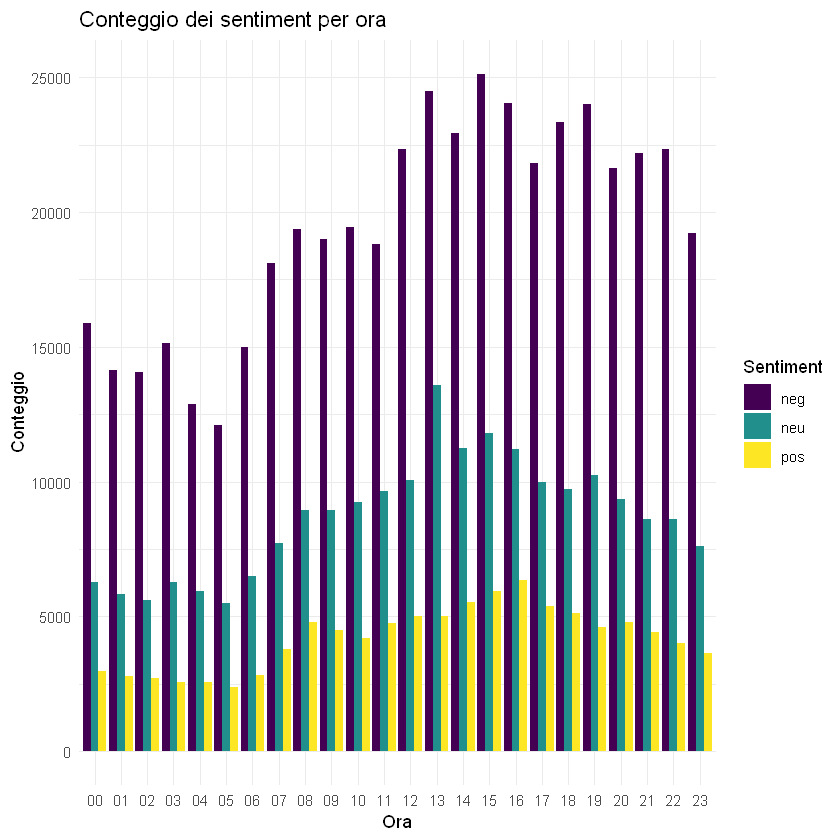

In [6]:
library(ggplot2)

ggplot(conteggio_sentiment, aes(x = ora, y = conteggio, fill = sentiment)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Conteggio dei sentiment per ora", x = "Ora", y = "Conteggio") +
  theme_minimal() +
  scale_fill_viridis_d(name = "Sentiment")


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


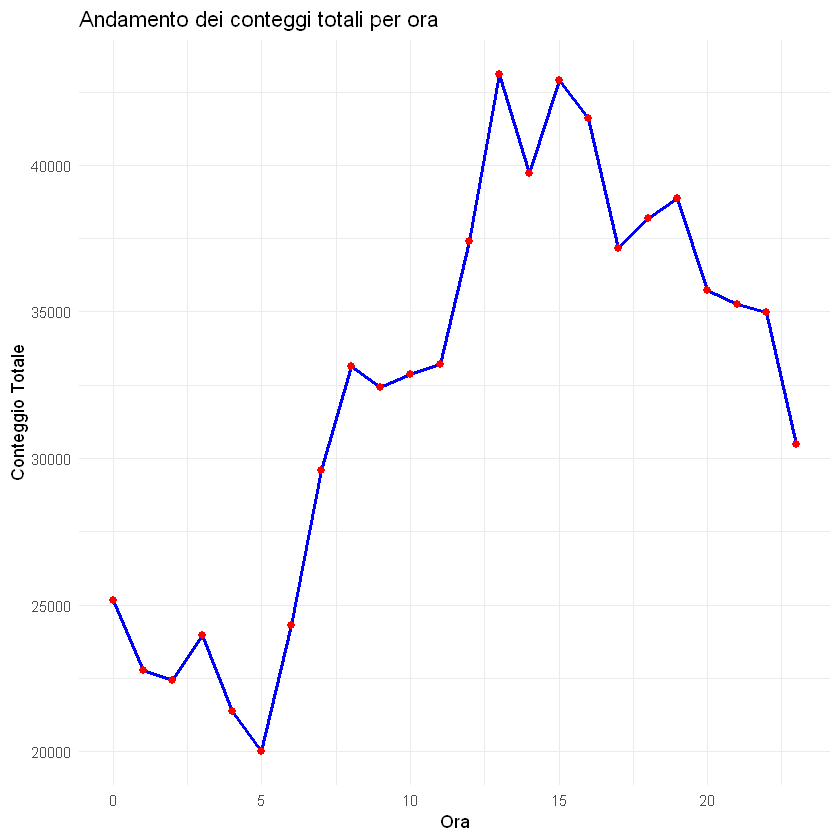

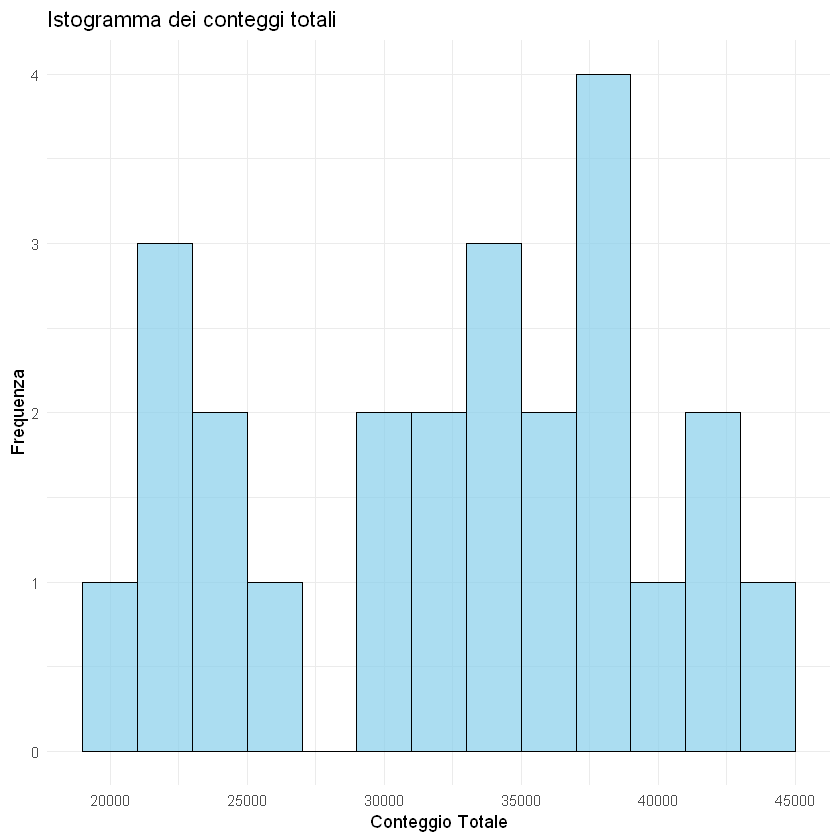

In [7]:
# Sommare i conteggi per ogni ora
data_tot <- aggregate(conteggio ~ ora, data = conteggio_sentiment, sum)

# Grafico a linee
ggplot(data_tot, aes(x = as.numeric(ora), y = conteggio)) +
  geom_line(size = 1, color = "blue") +
  geom_point(size = 2, color = "red") +
  labs(title = "Andamento dei conteggi totali per ora", x = "Ora", y = "Conteggio Totale") +
  theme_minimal()

# Istogramma
ggplot(data_tot, aes(x = conteggio)) +
  geom_histogram(binwidth = 2000, fill = "skyblue", color = "black", alpha = 0.7) +
  labs(title = "Istogramma dei conteggi totali", x = "Conteggio Totale", y = "Frequenza") +
  theme_minimal()


## 13.9 Verifica distribuzione che più si affina ai dati

In [14]:
install.packages("fitdistrplus")


  C'è una versione binaria disponibile, ma la versione con le sorgenti
  è successiva:
             binary source needs_compilation
fitdistrplus  1.1-8  1.2-1             FALSE



installazione pacchetto sorgenti 'fitdistrplus'




In [30]:
library(fitdistrplus)

# Fit delle distribuzioni
fit_norm <- fitdist(data_tot$conteggio, "norm")
fit_pois <- fitdist(data_tot$conteggio, "pois")
fit_lognorm <- fitdist(data_tot$conteggio, "lnorm")
fit_weibull <- fitdist(data_tot$conteggio, "weibull")
fit_nbinom <- fitdist(data_tot$conteggio, "nbinom")

# Creazione di un vettore con gli AIC di ciascun fit
aic_values <- c(
  norm = fit_norm$aic,
  pois = fit_pois$aic,
  lognorm = fit_lognorm$aic,
  weibull = fit_weibull$aic,
  nbinom = fit_nbinom$aic
)

# Identificazione della distribuzione con il miglior AIC
best_dist <- names(aic_values)[which.min(aic_values)]
best_aic <- min(aic_values)

# Stampa del risultato
cat("La distribuzione migliore è:", best_dist, "con un AIC di:", best_aic, "\n")

# Visualizzazione dei grafici
par(mfrow = c(3, 3))  # Layout dei grafici (9)
plot(fit_norm, main = "Normale")
plot(fit_pois, main = "Poisson")
plot(fit_lognorm, main = "Lognormale")
plot(fit_weibull, main = "Weibull")
plot(fit_nbinom, main = "Binomiale Negativa")
par(mfrow = c(1, 1))  # Reset layout


La distribuzione migliore è: weibull con un AIC di: 496.0852 


ERROR: Error in hist.default(data, freq = FALSE, xlab = "Data", ylim = c(0, ymax), : l'argomento formale "main" corrisponde con multipli argomenti passati


### 13.8.1 Stampa della distribuzione di weillbul

Fitting of the distribution ' weibull ' by maximum likelihood 
Parameters : 
          estimate   Std. Error
shape     5.495081    0.9124878
scale 35155.939887 1370.2812582
Loglikelihood:  -246.0426   AIC:  496.0852   BIC:  498.4413 
Correlation matrix:
          shape     scale
shape 1.0000000 0.3113664
scale 0.3113664 1.0000000


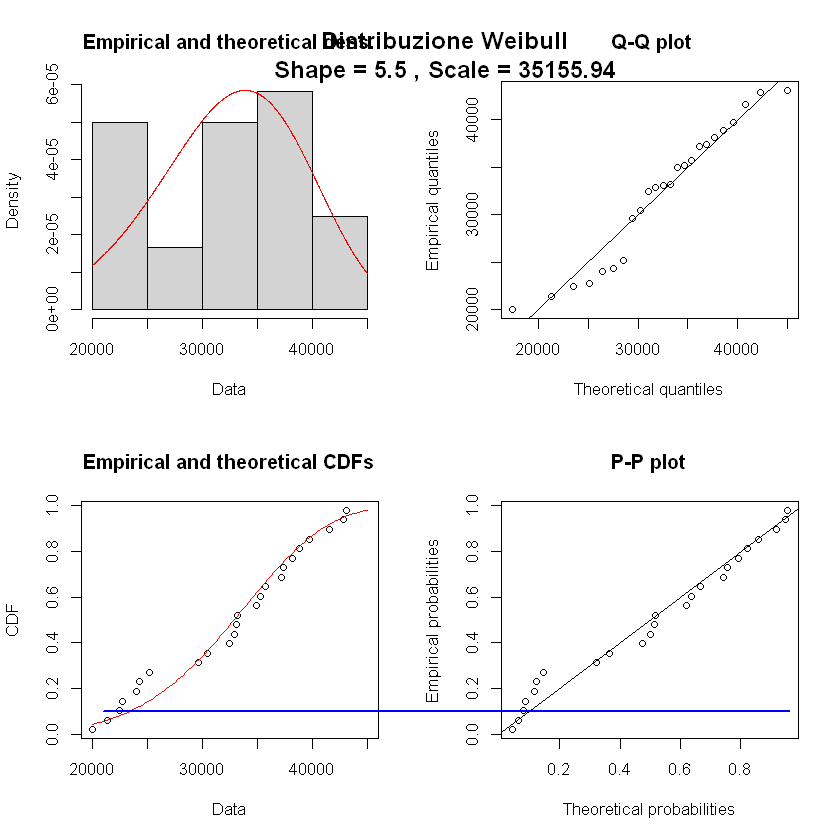

In [32]:
# Fit della distribuzione Weibull
fit_weibull <- fitdist(data_tot$conteggio, "weibull")

# Stampa un riepilogo del modello Weibull
summary(fit_weibull)

# Visualizzazione della distribuzione adattata
plot(fit_weibull)

# Aggiungo la curva della distribuzione Weibull alla visualizzazione
curve(dweibull(x, shape = fit_weibull$estimate[1], scale = fit_weibull$estimate[2]), 
      from = 0, to = max(data_tot$conteggio), col = "blue", lwd = 2, add = TRUE)

# Titolo informativo per la curva Weibull adattata
title(main = paste("Distribuzione Weibull\nShape =", round(fit_weibull$estimate[1], 2),
                   ", Scale =", round(fit_weibull$estimate[2], 2)))
